# Gym Churn Analysis

In [53]:
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram

In [54]:
try:
    gym = pd.read_csv('gym_churn_us.csv')
except:
    gym = pd.read_csv('/datasets/gym_churn_us.csv')

## Introduction

We have been given a dataset containing gym members information for analysis and prediction. In this report, we would analyse the following:
- probability of churn (for the upcoming month) for each customer
- typical user portraits: the most outstanding groups and their main features
- the factors that impact churn the most

We would also draw conclusions and provide recommendations on how to improve customer service by:
- identifying target groups
- suggesting measures to cut churn
- describing any other patterns with respect to interaction with customers

### Checking the Data

In [55]:
gym.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [56]:
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [57]:
gym.isnull().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

In [58]:
gym.duplicated().sum()

0

In [59]:
gym.columns = gym.columns.str.lower()

#### Conclusion
1. We have inspected the dataset and from the first five rows we found that 'contract_period' seems like a categorical variable with more than 2 levels, while features including 'gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits' are binary categorical variables
2. We found that the dataset does not contain any missing values or duplicates
2. We changed the column names to uniformed lowercase

## Exploratory Data Analysis

In this section we would look into the mean values and standard deviations of the features in the dataset. We would also look into the feature values of members who left (churn) and those who stay.

In [60]:
gym['contract_period'].value_counts()

1     2207
12     960
6      833
Name: contract_period, dtype: int64

There are three lengths of 'contract_period'. Customers join the gym on either a 1 month, 6 months or 12 months contract. Majority sign up for the 1 month membership.

In [61]:
gym.drop('contract_period', axis=1).describe().loc[['mean', 'std', 'min', 'max']].T

,mean,std,min,max
gender,0.510250,0.499957,0.000000,1.000000
near_location,0.845250,0.361711,0.000000,1.000000
partner,0.486750,0.499887,0.000000,1.000000
promo_friends,0.308500,0.461932,0.000000,1.000000
phone,0.903500,0.295313,0.000000,1.000000
group_visits,0.412250,0.492301,0.000000,1.000000
age,29.184250,3.258367,18.000000,41.000000
avg_additional_charges_total,146.943728,96.355602,0.148205,552.590740
month_to_end_contract,4.322750,4.191297,1.000000,12.000000
lifetime,3.724750,3.749267,0.000000,31.000000


From the table above, we can see that:
1. The majority of the customers live in the neighbourhood of the gym and they have their phone number on records 
2. The gender of the customers tend to be balanced 
3. Nearly half of all customers are employees in gym partner company
4. A third of all customers joined the gym through friends promo
5. Average age of the customers is 29 and the oldest on record is 41 years old, showing that this gym has a young crowd
6. On average, customers join the gym for 4 months, but there are some who stay for 31 months
7. Overall churn rate is slightly over 26%. Our binary target variable values are not distributed evenly. The customers in the data who didn't quit almost triple the size of those who did. We have to keep this in mind when later develop our algorithms.

Next, let's take a look at how the mean values of features vary between the customers who left and who didn't.

In [62]:
gym.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


We can note from the table above that those who quit the gym have lower number of members living closeby, having joined in after invited by a friend, being an employee of a partner company, and having joined a group class. These customers, compared to those who didn't quit, also have a shorter average gym contract period, a lower average extra spending, a shorter lifetime, and lower average frequency of attending classes per week.

This indicates that those features in particular: 'near_location', 'partner', 'promo_friends', 'contract_period', 'group_visits', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', and 'avg_frequency_class_current_month', will be useful predictors for customer churn.

Next let's plot the distribution of the features to have a more visual examination of them.

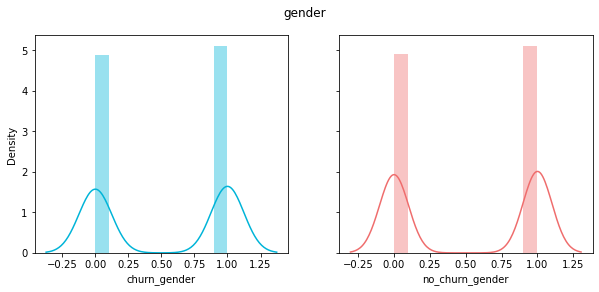

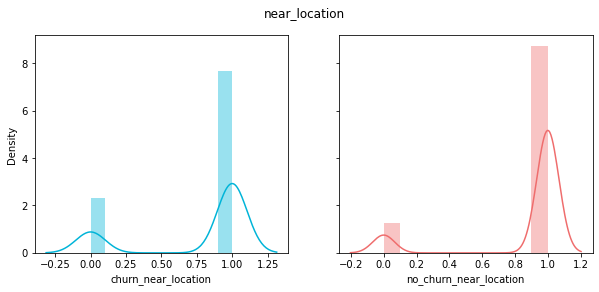

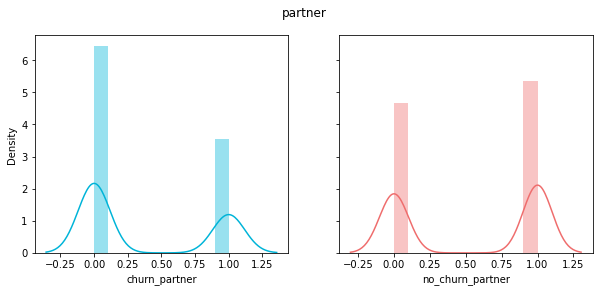

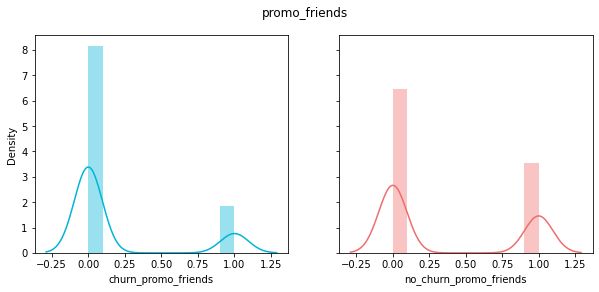

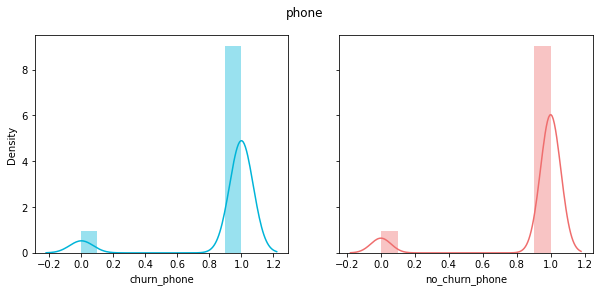

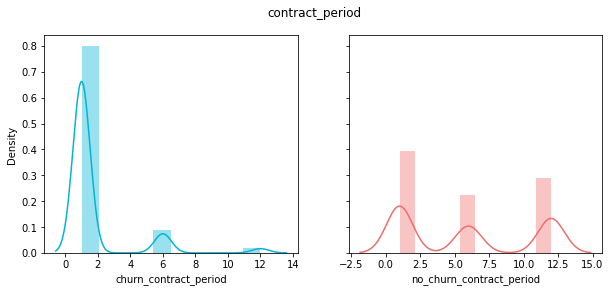

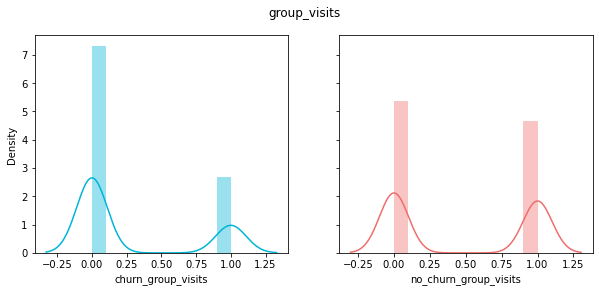

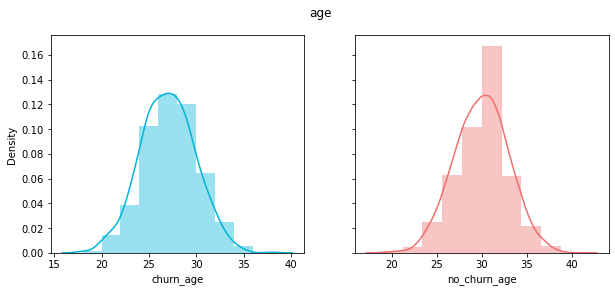

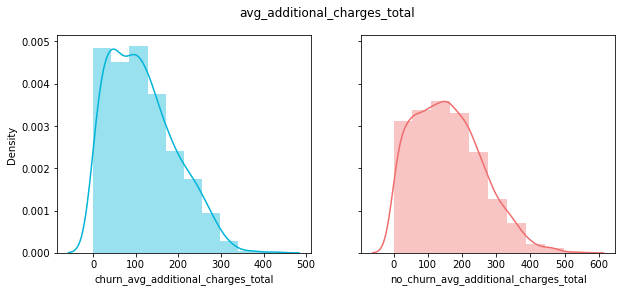

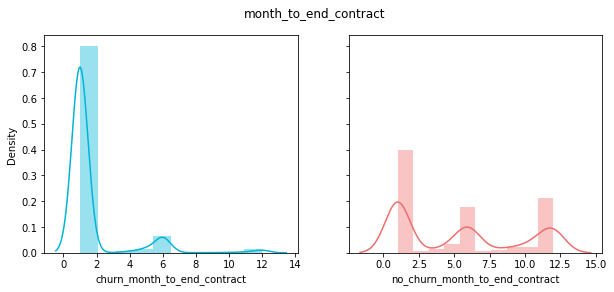

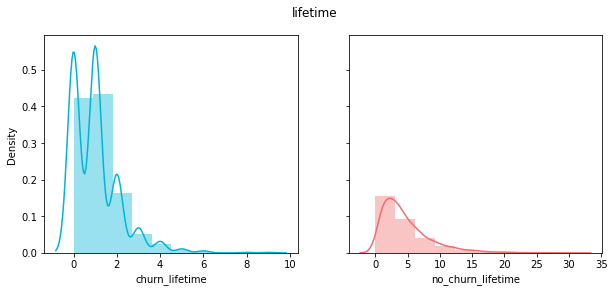

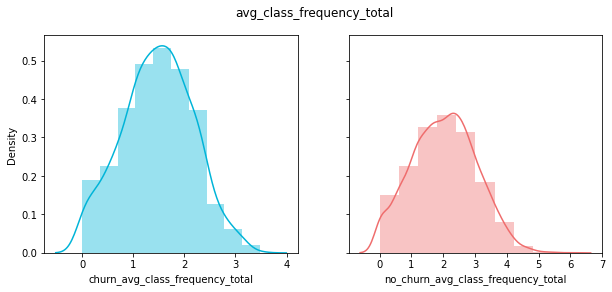

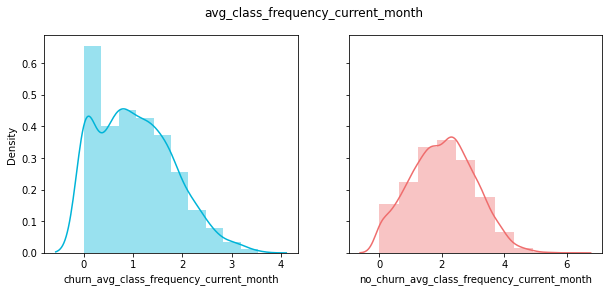

In [63]:
for feature in gym.drop('churn', axis=1).columns:
    fig, (ax1,ax2) = plt.subplots(1,2, sharey=True, figsize=(10, 4))
    sns.distplot(gym.query('churn == 1')[feature], bins=10, ax=ax1, color='#00B4D8')
    ax1.set_xlabel('_'.join(['churn', feature]))
    sns.distplot(gym.query('churn == 0')[feature], bins=10, ax=ax2, color='#EF6D6D')
    ax2.set_xlabel('_'.join(['no_churn', feature]))
    plt.suptitle(feature)
    plt.show()

The graphs show that the biggest discrepancy is shown on 'near_location', 'partner', 'promo_friends', 'contract_period', 'group_visits', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', and 'avg_frequency_class_current_month'. This is consistent with the previous conclusions when analysing the mean feature values between the groups. 

Now we will plot the correlation matrix.

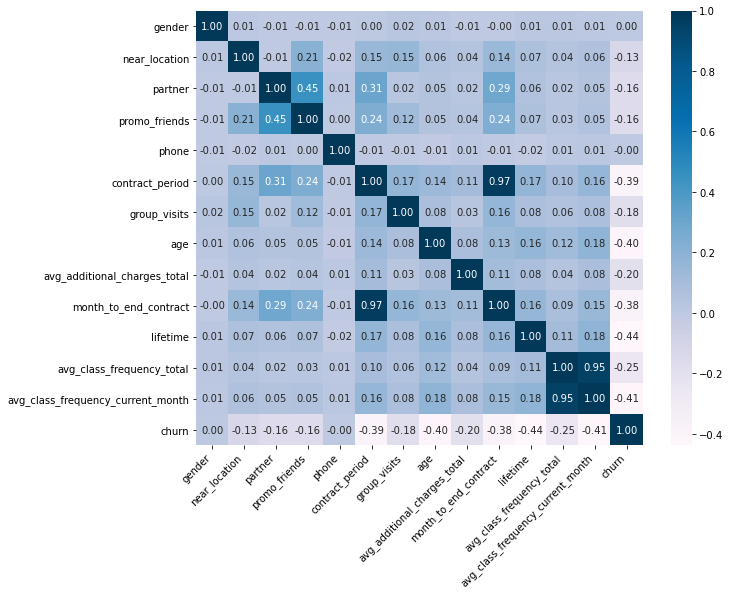

In [64]:
#plotting the correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(gym.corr(), 
            annot=True,
            cmap='PuBu',
            fmt='.2f'
           )
plt.xticks(rotation=45, 
           ha='right'
          )
plt.show()

The heatmap above shows that 'contract period', 'lifetime', 'age', 'month to end contract', and 'average_class_frequency_current_month' seem to have a relatively higher correlation with customer churn than other features. 

We can also see that 'month_to_end_contract' and 'contract_period' are highly correlated, so are 'avg_class_frequency_total' and 'avg_class_frequency_current_month'. To understand more on how these features are correlated, let's build a scatterplot for each pair.

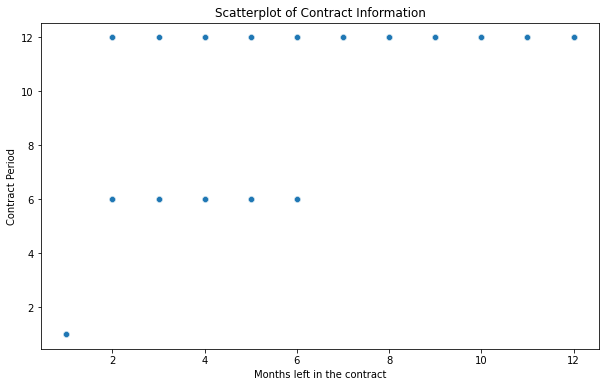

In [65]:
plt.figure(figsize=(10, 6))
sns.scatterplot(gym['month_to_end_contract'], gym['contract_period'])

plt.title('Scatterplot of Contract Information')
plt.xlabel('Months left in the contract')
plt.ylabel('Contract Period');

We can see from the above scatterplot that, contract period does decide how many months the customers have left in their current contract.

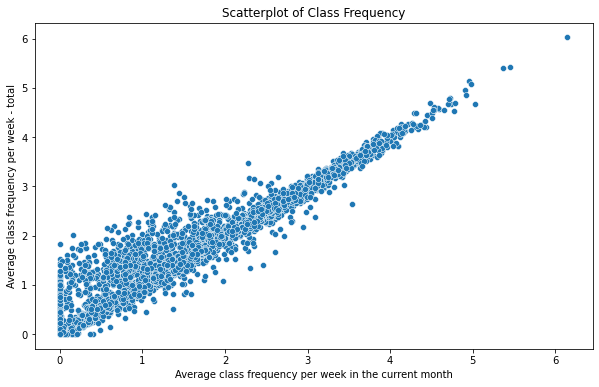

In [66]:
plt.figure(figsize=(10, 6))
sns.scatterplot(gym['avg_class_frequency_current_month'], gym['avg_class_frequency_total'])

plt.title('Scatterplot of Class Frequency')
plt.xlabel('Average class frequency per week in the current month')
plt.ylabel('Average class frequency per week - total');

In the scatterplot above, the average class frequency per week is showing a linear relation with those in the current month as well as how the total are related.

To fit a logistic regression and random forest model later in the analysis, we do need to remove the multicollinearity among the features. In this case, we will choose to keep 'avg_class_frequency_current_month' and remove 'avg_class_frequency_total' as the former shows a slightly higher correlation with customer churn (-0.41 v.s -0.25).

'contract_period' and 'month_to_end_contract' are also highly correlated related, but they are not the same features and we can argue that the number of months left in the contract might affect decision to churn in different ways as the total duration of the contract. In order not to lose valuable information, we will keep both. Of course, ideally we can compare the models with and without one of them to see if its accuracy can be improved.

#### Conclusion

We have done the exploratory data analysis in this section and found that:

1. the data does not have obvious outliers
2. there are 13 features where 6 are binary variables, 6 are numeric variables, and there is 1 that is a categorical variable with 3 length categories ('contract_period')
3. the highly correlated variables are 'avg_class_frequency_total' and 'avg_class_frequency_current_month', as well as 'month_to_end_contract' and 'contract_period';
4. mean feature values and graphs show that the features that differ most obviously between the churn and nonchurn customers are: 'partner', 'promo_friends', 'contract_period', 'group_visits', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', and 'avg_frequency_class_current_month';
5. correlation matrix shows that'contract_period', 'month_to_end_contract', 'life_time, 'age', and 'average_class_frequency_current_month' have a relatively higher correlation to customer churn than other features.

## Predicting User Churn

### Data Preprocessing

In [17]:
#transform the categorical column
gym_t = pd.get_dummies(gym, columns=['contract_period'])
gym_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   group_visits                       4000 non-null   int64  
 6   age                                4000 non-null   int64  
 7   avg_additional_charges_total       4000 non-null   float64
 8   month_to_end_contract              4000 non-null   float64
 9   lifetime                           4000 non-null   int64  
 10  avg_class_frequency_total          4000 non-null   float64
 11  avg_class_frequency_current_month  4000 non-null   float

As concluded above, we will drop 'avg_class_frequency_total', and split the dataframe into features: X, and target variable: y. We will keep all other features in our first attempt to fit machine learning models.

Then we will split the data into training and validation sets. We split the data with the random splitting method, as that takes into account the fact that the observations in the data provided are independent from one another, hence the prediction of customer churn is independent as well. Moreover, we have no knowledge of when the customer information is collected. All we have is whether they quit the gym or not and their profile information in the preceding month.

We will prepare two sets of training and test data, raw and standardized. For the logistic regression model, although the model is not sensitive to the mignitute of the variables, we will still use standardize feature values as we want to take a look at the information of feature coefficients. For developing the random forest model, we will just use the raw data as the model is not sensitive to the magnitude of the variables.

Later in the cluster analysis, we will also use the standardized datasets as clustering models are distance based algorithms, but we will use the whole feature dataset for that purpose.

In [18]:
X = gym_t.drop(['churn','avg_class_frequency_total'], axis=1)
y = gym_t['churn']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [20]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [50]:
#find mean and standard deviation of the standardized training and validation data
print('Mean of training data:', X_train_st.mean())
print('Standard deviation of training data:', X_train_st.std())

print('Mean of validation data:', X_test_st.mean())
print('Standard deviation of validation data:', X_test_st.std())

Mean of training data: -2.585233614484293e-17
Standard deviation of training data: 0.9999999999999999
Mean of validation data: -0.013076768139053962
Standard deviation of validation data: 1.006729855660226


As we would expect, the validation data standardized using the model trained on training data has a mean not exactly 0 but close, and a close to 1 standard deviation as well.

### Training & Evaluating the Model

In [22]:
# Defining models to check
models = [LogisticRegression(random_state=0, max_iter=1000), # Increasing the maximum iteration to allow convergence
          RandomForestClassifier(random_state=0)]
models_names = ['Logistic Regression',
                'Random Forest']

# Defining a function for training and evaluating models
def make_prediction(model, model_name, X_train, y_train, X_test, y_test):
    """ Taking the model and the data as input and outputing metrics. """
    # Training models
    model.fit(X_train, y_train)
    # Predicting
    y_pred = model.predict(X_test)
    # Evaluating accuracy, precision, and recall for both models using the validation set
    print('The metrics for the "{}" model are:\nAccuracy: {:.2f}\nPrecision: {:.2f}\nRecall: {:.2f}\n'
         .format(model_name,
                 accuracy_score(y_test, y_pred),
                 precision_score(y_test, y_pred),
                 recall_score(y_test, y_pred)))
    return

# Calculating metrics
for i in range(0,len(models)):
    make_prediction(models[i], models_names[i], X_train, y_train, X_test, y_test)

The metrics for the "Logistic Regression" model are:
Accuracy: 0.90
Precision: 0.79
Recall: 0.82

The metrics for the "Random Forest" model are:
Accuracy: 0.89
Precision: 0.80
Recall: 0.74



Comparing the performance of the models, we see that the resulting metrics for the Logistic Regression model are better than those of the Random Forest model, although only with slight margin.

### Clustering Users

In [25]:
# Removing the target
X_clustering = gym.drop(['churn'], axis=1)

# Training the scaler on the data and transforming it
X_clustering_st = scaler.fit_transform(X_clustering)

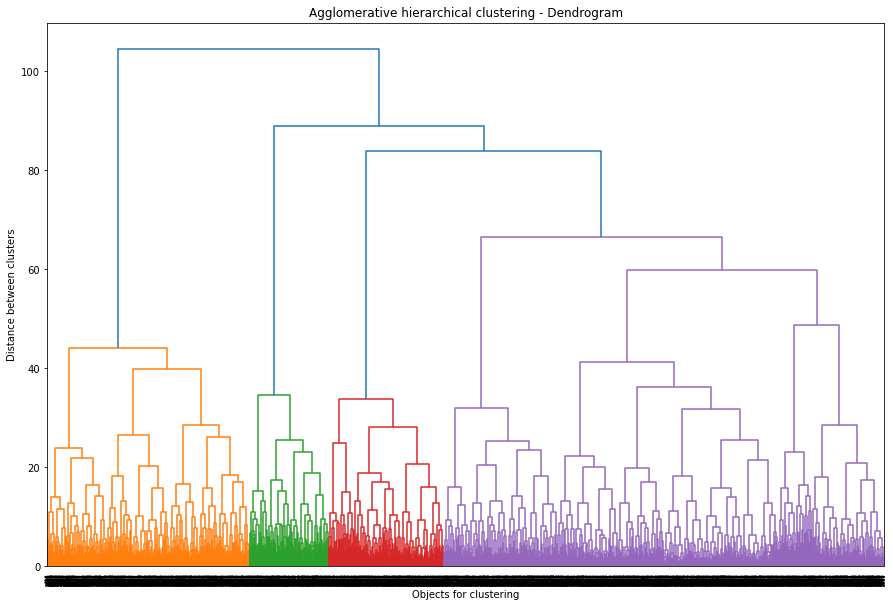

In [26]:
# Calculating a matrix of distances based on the standardized feature matrix
linked = linkage(X_clustering_st, method = 'ward')

# Presenting a dendogram of the clustering
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Agglomerative hierarchical clustering - Dendrogram')
plt.ylabel('Distance between clusters')
plt.xlabel('Objects for clustering')
plt.show()

We visualized data clusters with the dendrogram. The suggested optimal number of clusters (5) corresponds to the five different colors on the plot.

### K-Means Clustering

In [27]:
# Training the model
km = KMeans(n_clusters = 5, random_state = 0)

# Predicting customer clusters, by applying the model to the data to form a cluster vector
clusters = km.fit_predict(X_clustering_st)

In [28]:
# Adding the clusters to the data
gym['cluster'] = clusters

# Looking at the mean feature values for the clusters
gym.groupby(['cluster']).mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


There are some differences in the churn rate among the clusters, with cluster 0 has a churn rate less than 3%, whereas cluster 3 has more than 50%.

We also found some the following notes about the clusters: 

- cluster 2 doesn't have any member living close to the gym while other clusters have more than 80-100% members live nearby;
- cluster 3 has the lowest number of members who are employee of a partner company;
- cluster 2 has the lowest rate of customers signed up through the friend promo;
- cluster 1 has no member with phone number on file;
- cluster 3 has the lowest contract period and average additional charges;
- most members in clust 0 stay on average nearly 10 months, while other clusters mostly stay 4.5 months or less, cluster 3 has the lowest month-to-end at less than 2 months;

At this point, we can see that higher churn rate is related to members not being an employee to the partner company, low contract period, average additional charge, month to end contract and average class frequency.

### Clusters Distribution

In [31]:
# Creating useful variables
clusters_data = []
for i in list(range(0, 5)):
    clusters_data.append(gym.query('cluster == @i'))
    print('There are {} customers in cluster {}.'.format(len(clusters_data[i]), i))

There are 1010 customers in cluster 0.
There are 385 customers in cluster 1.
There are 505 customers in cluster 2.
There are 1262 customers in cluster 3.
There are 838 customers in cluster 4.


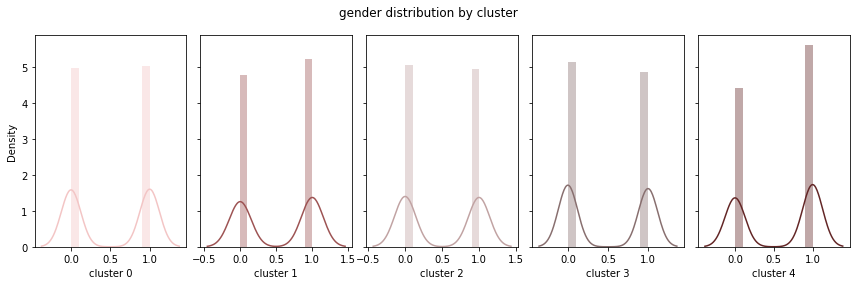

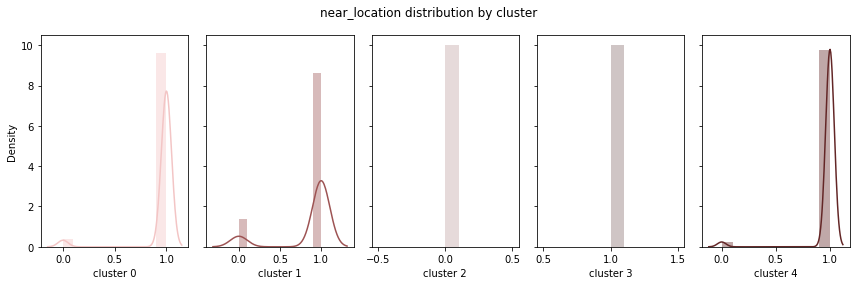

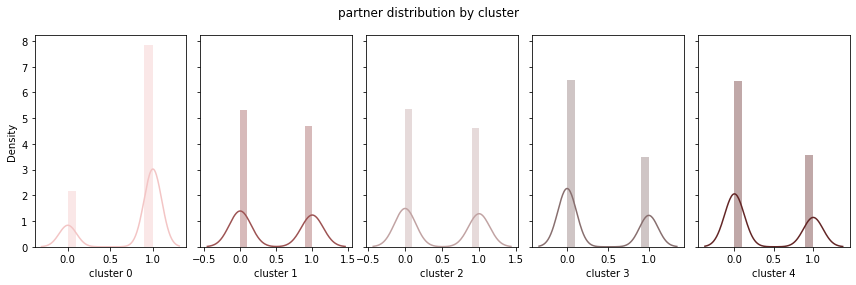

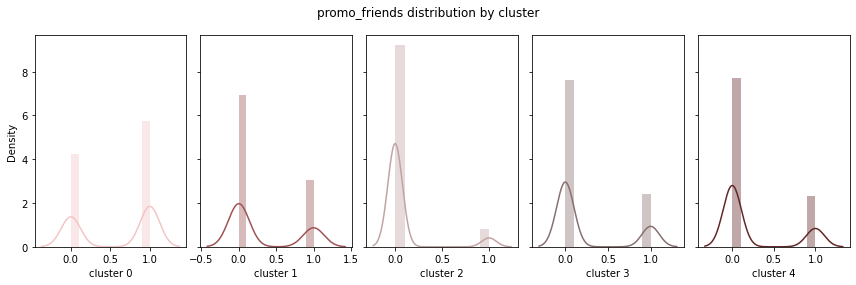

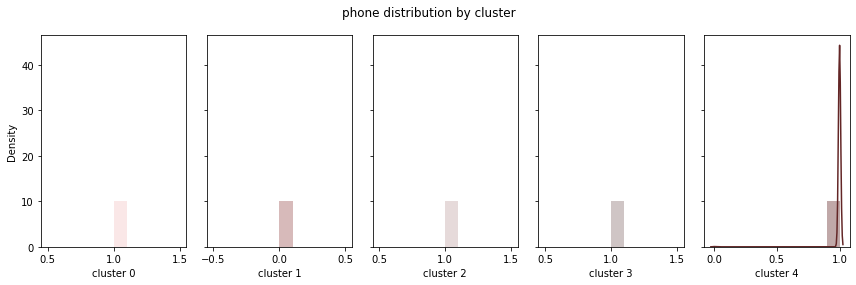

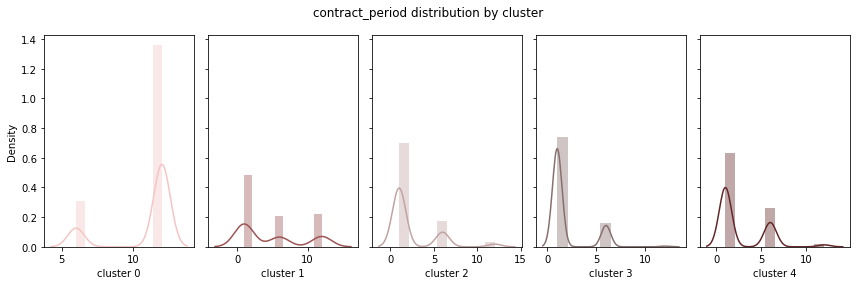

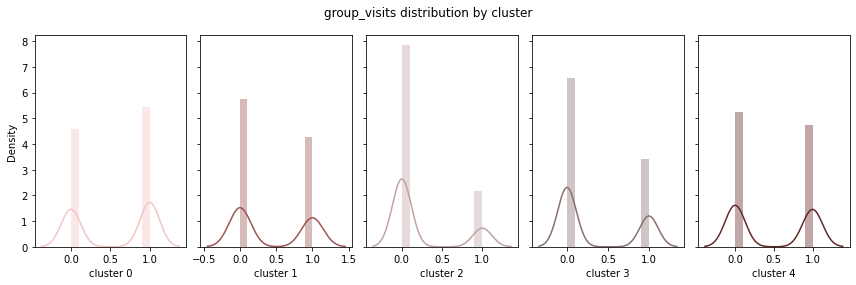

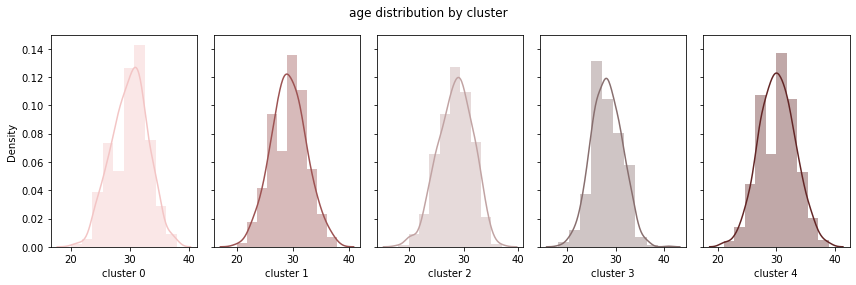

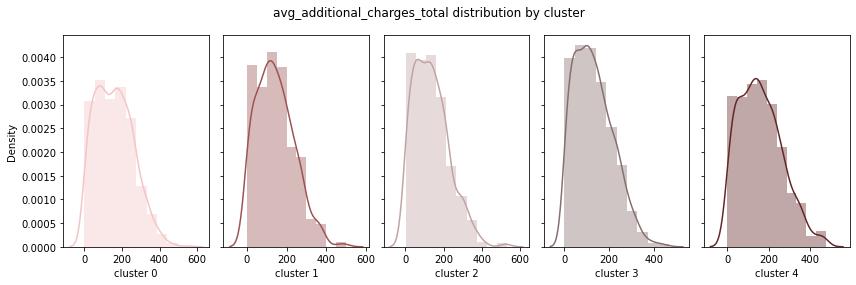

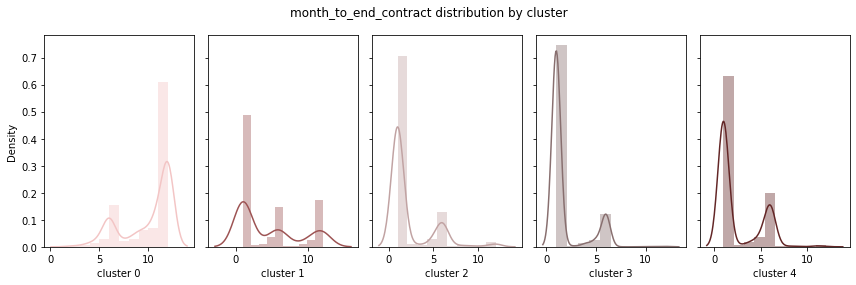

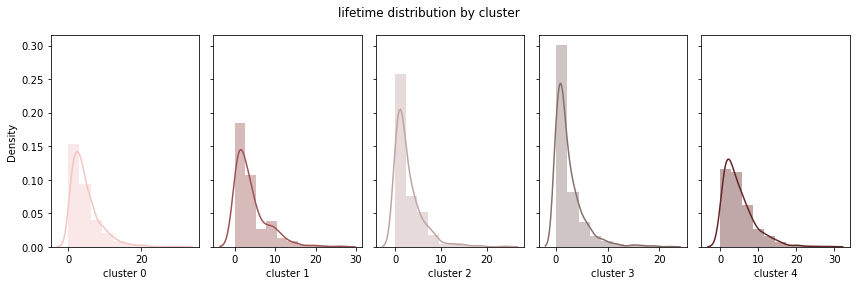

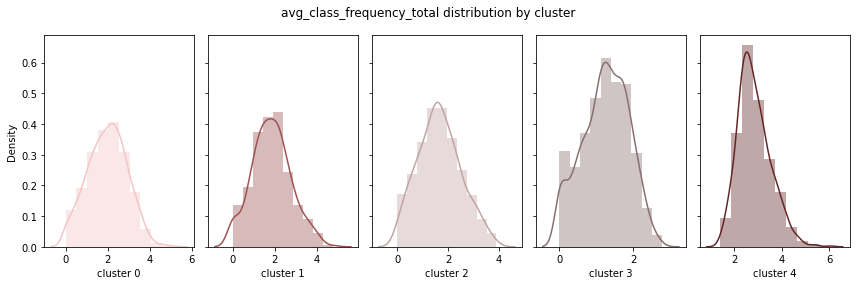

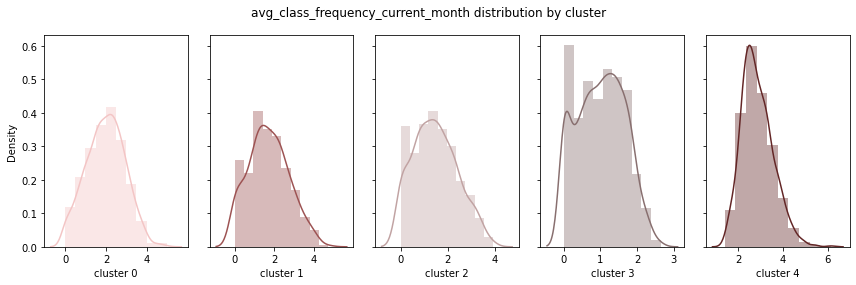

In [36]:
for feature in gym.drop(['churn', 'cluster'], axis=1).columns:
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True, figsize=(12, 4))
    
    sns.distplot(gym.query('cluster == 0')[
        feature], bins=10, ax=ax1, color='#F3C5C5')
    ax1.set_xlabel('cluster 0')

    sns.distplot(gym.query('cluster == 1')[
        feature], bins=10, ax=ax2, color='#9D5353')
    ax2.set_xlabel('cluster 1')

    sns.distplot(gym.query('cluster == 2')[
        feature], bins=10, ax=ax3, color='#C1A3A3')
    ax3.set_xlabel('cluster 2')

    sns.distplot(gym.query('cluster == 3')[
        feature], bins=10, ax=ax4, color='#886F6F')
    ax4.set_xlabel('cluster 3')
    
    sns.distplot(gym.query('cluster == 4')[
        feature], bins=10, ax=ax5, color='#632626')
    ax5.set_xlabel('cluster 4')

    plt.suptitle(' '.join ([feature, 'distribution by cluster']))
    plt.tight_layout()

Based on the distribution plots above, we can see that there are not always clear distinction among all the clusters for each feature. Cluster 3 which has the highest churn rate does not always perform the worst in terms of particular features.

Cluster 2 has the lowest members signing up through friends promo and group visits. Cluster 3 has better average class frequency as well.

Finally, let's take a look at the mean Silhouette Coefficient of all samples.

In [43]:
silhouette_score(X_clustering_st, clusters)

0.14140953623023353

The value above is positive, but closer to 0 than to 1. This indicates that there might be overlapping clusters. If we take a look at the mean feature values of the clusters, we can notice that the mean values across some features among the clusters are not that far apart. 

### Clusters' Churn Rate

In [47]:
churn_rate = gym.groupby('cluster')['churn'].mean()
churn_rate = churn_rate.sort_values(ascending=False)
churn_rate

cluster
3    0.514263
2    0.443564
1    0.267532
4    0.068019
0    0.027723
Name: churn, dtype: float64

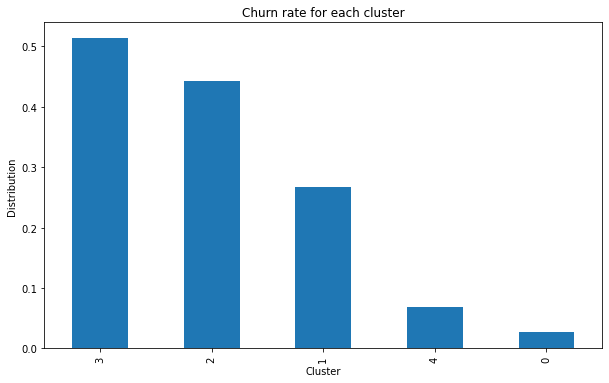

In [51]:
churn_rate.plot(kind='bar', figsize=(10,6), x='cluster_km', y='churn')
plt.title('Churn rate for each cluster')
plt.xlabel('Cluster')
plt.ylabel('Distribution')
plt.show();

#### Conclusion

1. In this section, we have plot a dendrogram Cluster 3 has the highest churn and cluster 0 has the lowest.
2. Some distinct characteristics of Cluster 3 are:
- lowest number of members who are employee of a partner company;
- lowest contract period;
- lowest average additional charges;
- highest number of members living nearby;
3. Some distinct characteristics of Cluster 0 are:
- highest number of members who are employee of a partner company and joining from friends promo;
- highest contract period;
- highest group visit;
- highest additional charges;
- longest month-to-end contract.

## Overall Conclusion & Recommendation

1. We have examined the dataset, we did not find missing values or duplicates, we preprocess them by making the column names all lowercase.
2. We conducted an exploratory data analysis to find any outliers and highly correlated variables. There was no obvious outliers and we found some highly correlated variables: 'avg_class_frequency_total' and 'avg_class_frequency_current_month', as well as 'month_to_end_contract' and 'contract_period'.
3. We trained Logistic Regression and Random Forest models and validated them. We found that Logistic Regression is slightly better.
4. We clustered the users into 5 clusters, we found cluster 3 to have the highest churn rate while cluster 0 is the lowest.
5. Some of the variables that is distinct in both of these clusters and might affect their churn rate are:
- whether the member lives nearby
- whether the member is an employee of the partner companies
- whether the member joined through friends promo
- how long is their contract period
- how much is their additional charges
- whether they do group visit
6. The recommendations we can provide based on the conclusions above are:
- increase more partner companies so that their employees can join and stay longer at the gym
- increase members' contract period by giving discounts and promotions for longer contract
- provide more ala carte charges rather than including more things in the membership fee (consequently may increase additional charges), so that people don't feel like spending a lot for gym membership.